In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import FDTDIResponseGenerator
from Triangle_BBH.Utils import Likelihood, Fstatistics
from Triangle_BBH.Fisher import *

import multiprocessing
if __name__=='__main__':
    multiprocessing.set_start_method("fork")
    
import bilby 

np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 
no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


## Data settings 

In [2]:
t_start = 200. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 15. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(14401,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((14137,), (14137,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_CPU = Orbit(OrbitDir="/Users/taijidatacenter/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.5 * Tobs) / DAY, (t_end - 0.1 * Tobs) / DAY] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 2.02500000e+02,  2.04500000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [6]:
intrinsic_param_priors[4]

array([202.5, 204.5])

## Noise model 

In [7]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 14137), (14137, 3, 3))

## Data simulation 

In [8]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 1540834.0744329947
mass_ratio : 0.7085556468373223
spin_1z : -0.13209939443812901
spin_2z : 0.5094582566568905
coalescence_time : 204.07674981626366
coalescence_phase : 0.22723542654969606
luminosity_distance : 78958.20214893804
inclination : 1.0242620672883695
longitude : 1.3208186729980294
latitude : 0.34319743322074053
psi : 0.4614176140098712
optimal SNR: 1539.581948810808


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

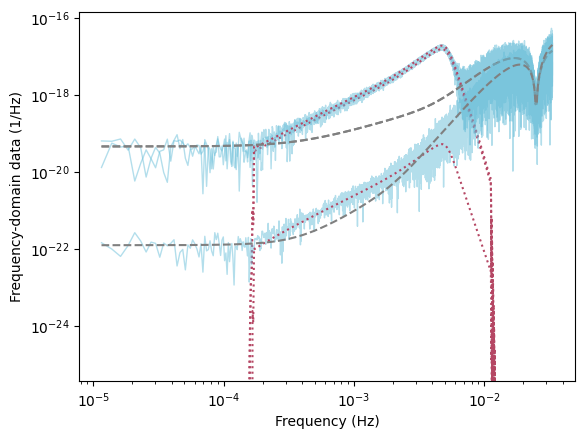

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [10]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

### optimization from prior 

In [11]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    # vectorized=True,
    workers=-1, 
)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [12]:
print(DE_result)

             message: Optimization terminated successfully.
             success: True
                 fun: -1184069.6160199651
                   x: [ 6.879e-01  6.650e-01  4.615e-01  7.355e-01
                        7.884e-01  8.598e-01  2.312e-01]
                 nit: 194
                nfev: 95638
          population: [[ 6.879e-01  6.650e-01 ...  8.598e-01  2.312e-01]
                       [ 6.879e-01  6.648e-01 ...  8.582e-01  2.292e-01]
                       ...
                       [ 6.879e-01  6.667e-01 ...  8.596e-01  2.331e-01]
                       [ 6.879e-01  6.647e-01 ...  8.586e-01  2.327e-01]]
 population_energies: [-1.184e+06 -1.184e+06 ... -1.184e+06 -1.184e+06]
                 jac: [ 3.073e+00 -3.322e+01  5.541e+01  4.238e+01
                        7.876e+03  1.793e+01  1.425e+01]


### reconstruct parameters and waveforms 

In [13]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | true value | difference")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

parameter name | true value | difference
chirp_mass 1540834.0744329947 550.9892838068772
mass_ratio 0.7085556468373223 0.010027134630872458
spin_1z -0.13209939443812901 0.0628581642557422
spin_2z 0.5094582566568905 0.08557742366141086
coalescence_time 204.07674981626366 4.4961492449147045e-06
longitude 1.3208186729980294 4.081301997310666
latitude 0.34319743322074053 0.9107576096716403
luminosity_distance 78958.20214893804 873.6197009600146
inclination 1.0242620672883695 1.0896081285693293
psi 0.4614176140098712 0.19406132877471755
coalescence_phase 0.22723542654969606 0.001134209366339456


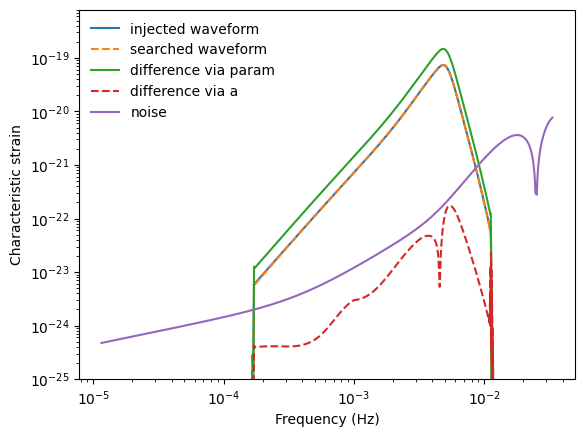

In [14]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference via param")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="--", label="difference via a")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [15]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 650.5974997522401,
 'mass_ratio': 0.009192807222197341,
 'spin_1z': 0.05575334122433358,
 'spin_2z': 0.078214360382689,
 'coalescence_time': 2.84060525904424e-06,
 'coalescence_phase': 0.007776735916496358,
 'luminosity_distance': 2243.9284975924165,
 'inclination': 0.006202157020509391,
 'longitude': 0.07102029968841791,
 'latitude': 0.060442213404913916,
 'psi': 0.03299698907340333}

In [16]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 550.9892838068772 650.5974997522401 0.8468973274823596
mass_ratio 0.010027134630872458 0.009192807222197341 1.090758719127767
spin_1z 0.0628581642557422 0.05575334122433358 1.1274331345061652
spin_2z 0.08557742366141086 0.078214360382689 1.0941395319567364
coalescence_time 4.4961492449147045e-06 2.84060525904424e-06 1.5828138142740376
longitude 4.081301997310666 0.07102029968841791 57.46669635605959
latitude 0.9107576096716403 0.060442213404913916 15.06823721974411
luminosity_distance 873.6197009600146 2243.9284975924165 0.38932599764090053
inclination 1.0896081285693293 0.006202157020509391 175.68212558408243
psi 0.19406132877471755 0.03299698907340333 5.881182926812478
coalescence_phase 0.001134209366339456 0.007776735916496358 0.14584645518610456


## Nested sampling with bilby 

### Prior

In [17]:
priors = bilby.core.prior.PriorDict()
priors["chirp_mass"] = bilby.prior.Uniform(minimum=searched_params["chirp_mass"]-10.*FIM.param_errors["chirp_mass"], maximum=searched_params["chirp_mass"]+10.*FIM.param_errors["chirp_mass"], name='chirp_mass', latex_label='$\mathcal{M}_c$')
priors["mass_ratio"] = bilby.prior.Uniform(minimum=max(0.1, searched_params["mass_ratio"]-10.*FIM.param_errors["mass_ratio"]), maximum=min(1., searched_params["mass_ratio"]+10.*FIM.param_errors["mass_ratio"]), name="mass_ratio", latex_label='$q$')
priors["spin_1z"] = bilby.prior.Uniform(minimum=max(-0.9, searched_params["spin_1z"]-10.*FIM.param_errors["spin_1z"]), maximum=min(0.9, searched_params["spin_1z"]+10.*FIM.param_errors["spin_1z"]), name="spin_1z", latex_label='$\chi_{z1}$')
priors["spin_2z"] = bilby.prior.Uniform(minimum=max(-0.9, searched_params["spin_2z"]-10.*FIM.param_errors["spin_2z"]), maximum=min(0.9, searched_params["spin_2z"]+10.*FIM.param_errors["spin_2z"]), name="spin_2z", latex_label='$\chi_{z2}$')
priors["coalescence_time"] = bilby.prior.Uniform(minimum=searched_params["coalescence_time"]-max(1e-3, 10.*FIM.param_errors["coalescence_time"]), maximum=searched_params["coalescence_time"]+max(1e-3, 10.*FIM.param_errors["coalescence_time"]), name="coalescence_time", latex_label='$t_c$') 
priors["coalescence_phase"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="coalescence_phase", latex_label='$\\varphi_c$', boundary="periodic")
priors["luminosity_distance"] = bilby.prior.Uniform(minimum=max(10**lgdl_prior[0], searched_params["luminosity_distance"]-5.*FIM.param_errors["luminosity_distance"]), maximum=min(10**lgdl_prior[1], searched_params["luminosity_distance"]+5.*FIM.param_errors["luminosity_distance"]), name="luminosity_distance", latex_label='$d_L$')
priors["inclination"] = bilby.prior.Sine(minimum=0., maximum=PI, name="inclination", latex_label='$\iota$')
priors["longitude"] = bilby.prior.Uniform(minimum=0., maximum=TWOPI, name="longitude", latex_label='$\lambda$', boundary="periodic")
priors["latitude"] = bilby.prior.Cosine(minimum=-PI/2., maximum=PI/2., name="latitude", latex_label='$\\beta$')
priors["psi"] = bilby.prior.Uniform(minimum=0., maximum=PI, name="psi", latex_label='$\psi$', boundary="periodic")

priors

{'chirp_mass': Uniform(minimum=1534879.0887192793, maximum=1547891.038714324, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.6066004399844764, maximum=0.7904565844284233, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'spin_1z': Uniform(minimum=-0.6267746424257226, maximum=0.48829218206094893, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None),
 'spin_2z': Uniform(minimum=-0.35826277083141045, maximum=0.9, name='spin_2z', latex_label='$\\chi_{z2}$', unit=None, boundary=None),
 'coalescence_time': Uniform(minimum=204.0757543124129, maximum=204.0777543124129, name='coalescence_time', latex_label='$t_c$', unit=None, boundary=None),
 'coalescence_phase': Uniform(minimum=0.0, maximum=6.283185307179586, name='coalescence_phase', latex_label='$\\varphi_c$', unit=None, boundary='periodic'),
 'luminosity_distance': Uniform(minimum=68612.17936193597, maximum=91051.46433786015, name='luminosity_d

### Likelihood

In [18]:
Like = Likelihood(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
)

Like.prepare_het_log_like(base_parameters=ParamDict2ParamArr(searched_params))

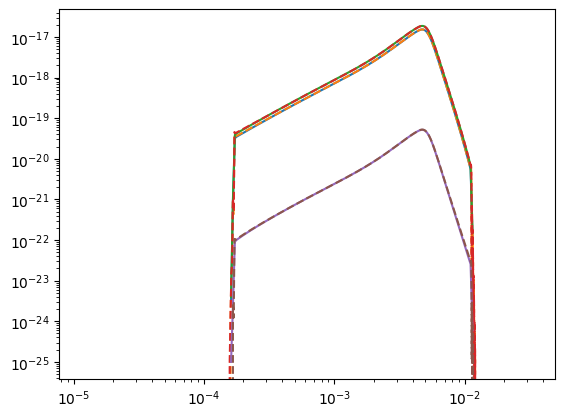

In [19]:
for i in range(3):
    plt.loglog(Like.het_frequency, np.abs(Like.het_h0[i]))
    plt.loglog(data_frequencies_CPU, np.abs(wf_channels[i]), linestyle="--")

(-2000.0, 0.0)

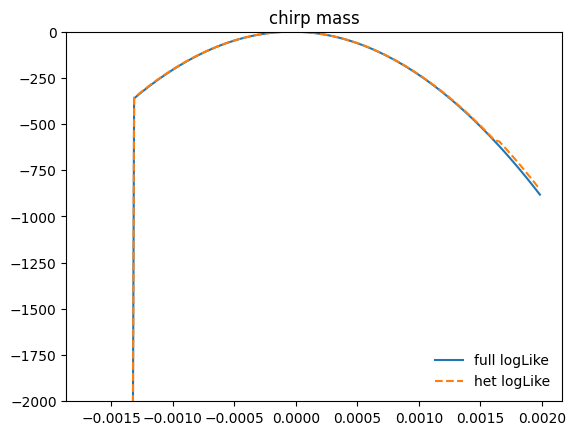

In [20]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)
# fiducial_param_arr = ParamDict2ParamArr(searched_params)

N_test=101
test_idx = 0 # lgMc 
# test_params = np.linspace(-1e-3, 1e-3, N_test) + fiducial_param_arr[test_idx]
test_params = np.linspace(np.log10(priors["chirp_mass"].minimum), np.log10(priors["chirp_mass"].maximum), N_test)

full_lls = [] # store the full loglikelihood 
het_lls = [] 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
    het_lls.append(Like.het_log_like(tmp_params))
full_lls = np.array(full_lls)
het_lls = np.array(het_lls)

plt.plot((test_params - fiducial_param_arr[test_idx]), full_lls - np.max(full_lls), label="full logLike")
plt.plot((test_params - fiducial_param_arr[test_idx]), het_lls - np.max(het_lls), label="het logLike", linestyle="--")
plt.legend(frameon=False)
plt.title("chirp mass")
plt.ylim(-2000, 0)

Text(0.5, 1.0, 'merger time')

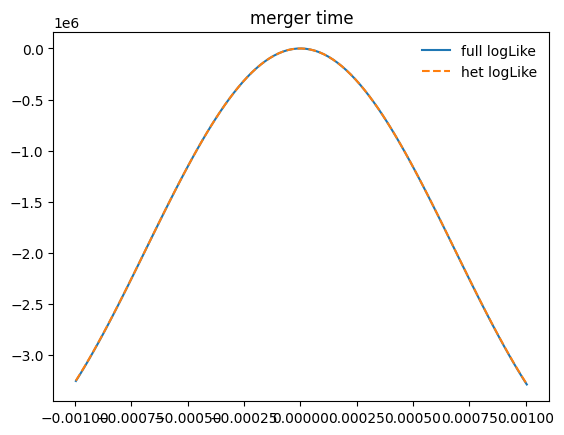

In [21]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)

N_test=101
test_idx = 4 # tc 
test_params = np.linspace(priors["coalescence_time"].minimum, priors["coalescence_time"].maximum, N_test)

full_lls = [] # store the full loglikelihood 
het_lls = [] 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
    het_lls.append(Like.het_log_like(tmp_params))
full_lls = np.array(full_lls)
het_lls = np.array(het_lls)

plt.plot((test_params - fiducial_param_arr[test_idx]), full_lls - np.max(full_lls), label="full logLike")
plt.plot((test_params - fiducial_param_arr[test_idx]), het_lls - np.max(het_lls), label="het logLike", linestyle="--")
plt.legend(frameon=False)
plt.title("merger time")
# plt.ylim(-2000, 0)

Text(0.5, 1.0, 'cos inclination')

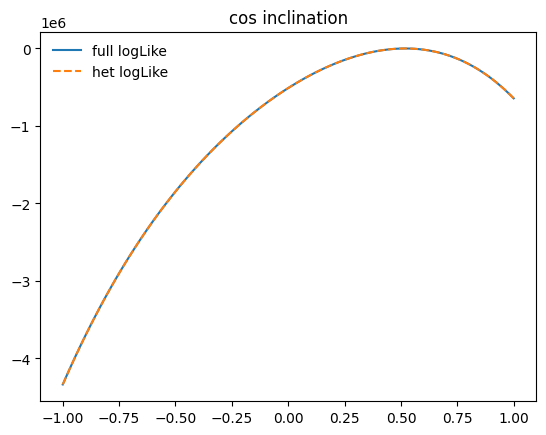

In [22]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)

N_test=101
test_idx = 7 # cosiota
test_params = np.linspace(-1., 1., N_test)

full_lls = [] # store the full loglikelihood 
het_lls = [] 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
    het_lls.append(Like.het_log_like(tmp_params))
full_lls = np.array(full_lls)
het_lls = np.array(het_lls)

plt.plot(test_params, full_lls - np.max(full_lls), label="full logLike")
plt.plot(test_params, het_lls - np.max(het_lls), label="het logLike", linestyle="--")
plt.legend(frameon=False)
plt.title("cos inclination")
# plt.ylim(-2000, 0)

Text(0.5, 1.0, 'longitude')

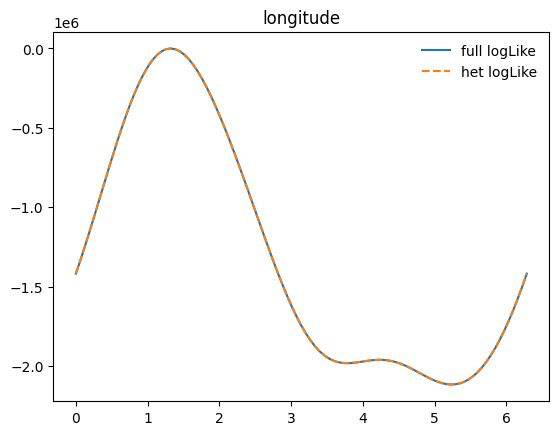

In [23]:
fiducial_param_arr = ParamDict2ParamArr(mbhb_parameters)

N_test=101
test_idx = 8 # longitude 
test_params = np.linspace(0, TWOPI, N_test)

full_lls = [] # store the full loglikelihood 
het_lls = [] 
for i_test in range(N_test):
    tmp_params = np.array(fiducial_param_arr).copy()
    tmp_params[test_idx] = test_params[i_test]
    full_lls.append(Like.full_log_like(tmp_params))
    het_lls.append(Like.het_log_like(tmp_params))
full_lls = np.array(full_lls)
het_lls = np.array(het_lls)

plt.plot(test_params, full_lls - np.max(full_lls), label="full logLike")
plt.plot(test_params, het_lls - np.max(het_lls), label="het logLike", linestyle="--")
plt.legend(frameon=False)
plt.title("longitude")
# plt.ylim(-2000, 0)

In [24]:
class bilby_likelihood_wrapper(bilby.Likelihood):
    def __init__(self, triangle_likelihood, likelihood_type="full"):
        """ wrap a triangle likelihood to get a bilby likelihood, type can be "full" or "heterodyned" """
        super().__init__(
            parameters={
                'chirp_mass': None,
                'mass_ratio': None,
                'spin_1z': None,
                'spin_2z': None,
                'coalescence_time': None,
                'coalescence_phase': None,
                'luminosity_distance': None,
                'inclination': None,
                'longitude': None,
                'latitude': None,
                'psi': None
            }
        )
        if likelihood_type == "full":
            self.LLfunc = triangle_likelihood.full_log_like
        elif likelihood_type == "heterodyned":
            self.LLfunc = triangle_likelihood.het_log_like
        else:
            raise ValueError("wrong likelihood type. it should only be full or heterodyned.")

    def log_likelihood(self):
        return self.LLfunc(ParamDict2ParamArr(self.parameters))

In [25]:
BLike_full = bilby_likelihood_wrapper(triangle_likelihood=Like, likelihood_type="full")
BLike_het = bilby_likelihood_wrapper(triangle_likelihood=Like, likelihood_type="heterodyned")

### sampling with het likelihood

In [26]:
import multiprocessing
print("number of cpus =", multiprocessing.cpu_count())

het_result = bilby.run_sampler(
    likelihood=BLike_het, 
    priors=priors,
    sampler="nessai", 
    nlive=1000,
    # walks=20,
    # nact=50,
    # maxmcmc=2000,
    stopping=0.5,
    npool=multiprocessing.cpu_count(),
    injection_parameters=mbhb_parameters, 
    outdir="../../MBHBPosteriors/bilby_outdir",
    label="test_het_likelihood",
    plot=True,
    resume=False, 
    # resume=True, 
)

10:13 bilby INFO    : Running for label 'test_het_likelihood', output will be saved to '../../MBHBPosteriors/bilby_outdir'


number of cpus = 12


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/bilby/core/utils/log.py:73: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
10:13 bilby INFO    : Analysis priors:
10:13 bilby INFO    : chirp_mass=Uniform(minimum=1534879.0887192793, maximum=1547891.038714324, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None)
10:13 bilby INFO    : mass_ratio=Uniform(minimum=0.6066004399844764, maximum=0.7904565844284233, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
10:13 bilby INFO    : spin_1z=Uniform(minimum=-0.6267746424257226, maximum=0.48829218206094893, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary=None)
10:13 bilby INFO    : spin_2z=Uniform(minimum=-0.35826277083141045, maximum=0.9, name='spin_2z', latex_label='$\\chi_

07-26 10:13 nessai INFO    : Running Nessai version 0.14.0.post0
07-26 10:13 nessai INFO    : Starting multiprocessing pool with 12 processes


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/nessai/utils/logging.py:133: FutureWarning: setup_logger is deprecated, use configure_logger instead
  warnings.warn(


07-26 10:13 nessai INFO    : Initialising nested sampler
07-26 10:13 nessai WARNING : Multiprocessing pool has already been configured.
07-26 10:13 nessai WARNING : Removing unused keyword arguments ({'plot_history', 'n_marg', 'step_kwargs', 'step_type', 'ensemble_fraction', 'augment_dims', 'enforce_likelihood_threshold', 'max_n_clusters', 'marginalise_augment', 'plot_chain', 'generate_augment', 'n_steps', 'n_accept'}) from kwargs for FlowProposal. These are valid keyword arguments but correspond to other proposal classes.
07-26 10:13 nessai INFO    : Passing kwargs to FlowProposal: {'training_config': None, 'poolsize': 1000, 'check_acceptance': False, 'max_poolsize_scale': 10, 'update_poolsize': True, 'accumulate_weights': False, 'save_training_data': False, 'reparameterisations': None, 'fallback_reparameterisation': 'zscore', 'use_default_reparameterisations': None, 'reverse_reparameterisations': False, 'map_to_unit_hypercube': False, 'latent_prior': 'truncated_gaussian', 'constant_v

14:54 bilby INFO    : Sampling time: 4:40:53.230740
14:54 bilby INFO    : Summary of results:
nsamples: 1842
ln_noise_evidence:    nan
ln_evidence: 1184022.817 +/-  0.204
ln_bayes_factor:    nan +/-  0.204



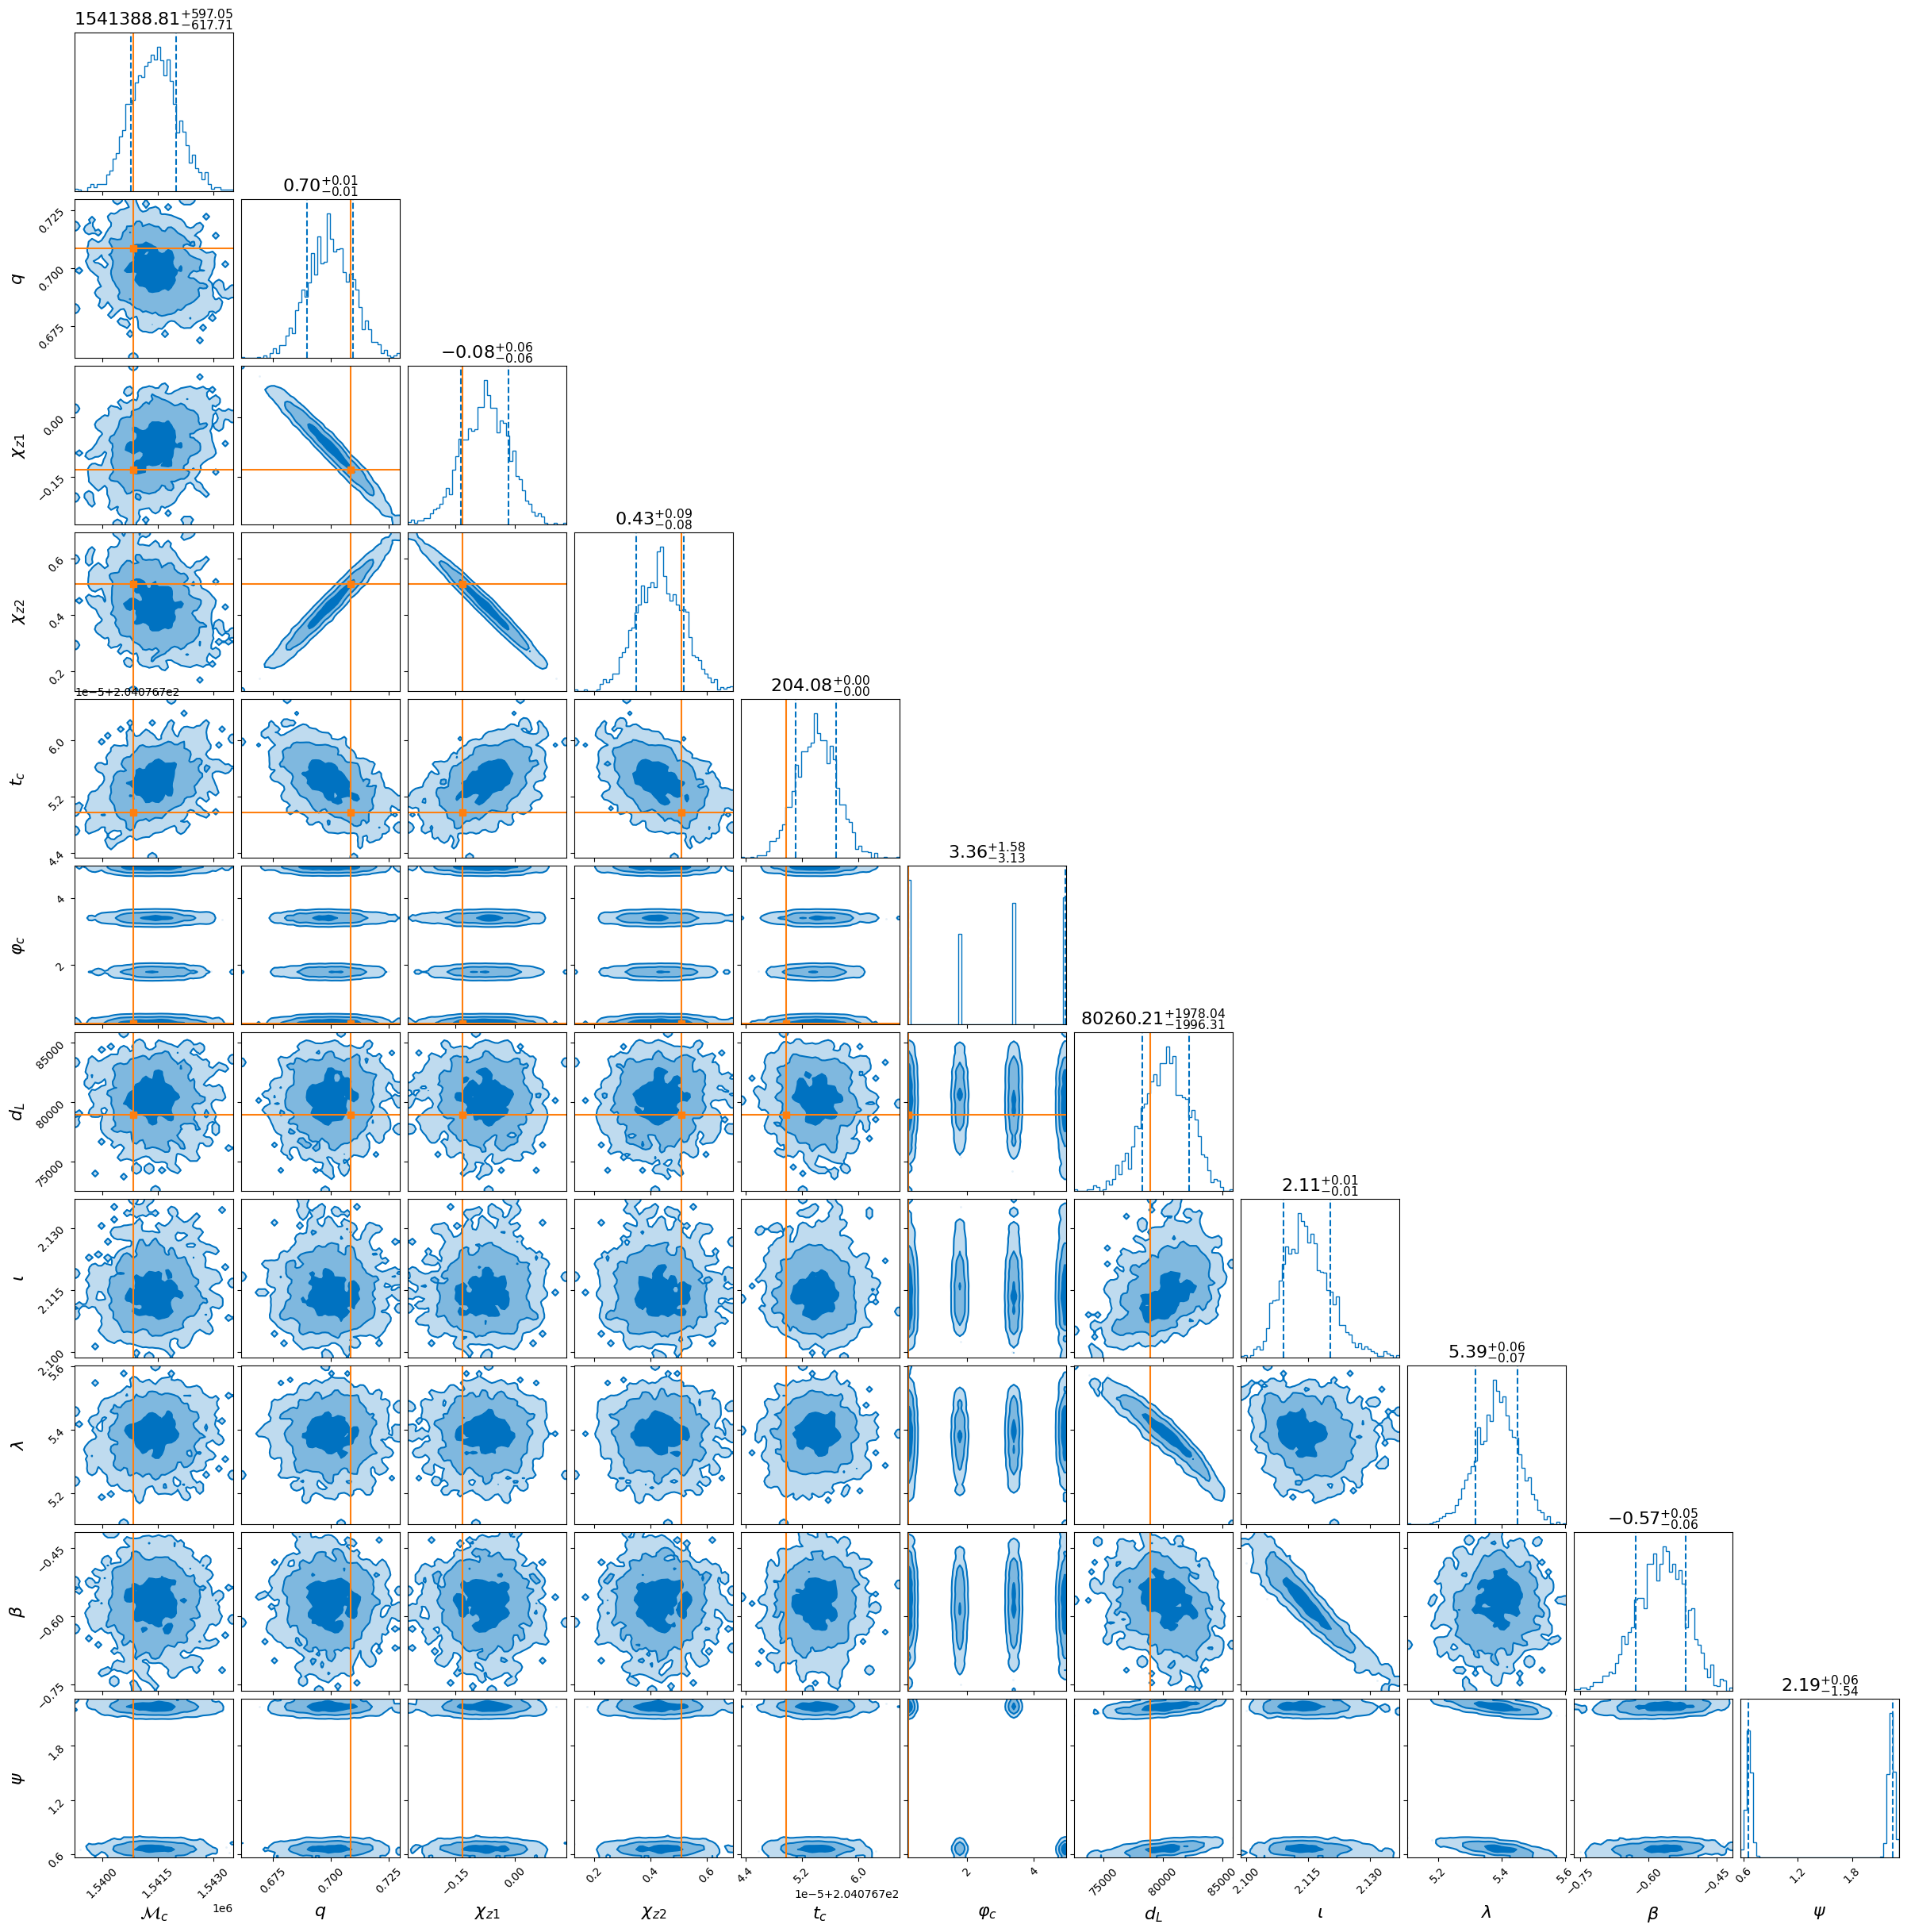

In [27]:
het_result.plot_corner(save=True)

In [ ]:
full_result = bilby.run_sampler(
    likelihood=BLike_full, 
    priors=priors,
    sampler="nessai", 
    nlive=1000,
    # walks=20,
    # nact=50,
    # maxmcmc=2000,
    stopping=0.5,
    npool=multiprocessing.cpu_count(),
    injection_parameters=mbhb_parameters, 
    outdir="../../MBHBPosteriors/bilby_outdir",
    label="test_full_likelihood",
    plot=True,
    resume=False, 
    # resume=True, 
)

22:06 bilby INFO    : Running for label 'test_full_likelihood', output will be saved to '../../MBHBPosteriors/bilby_outdir'
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/bilby/core/utils/log.py:73: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  vdict[key] = str(getattr(sys.modules[key], "__version__", "N/A"))
22:06 bilby INFO    : Analysis priors:
22:06 bilby INFO    : chirp_mass=Uniform(minimum=1534879.0887192793, maximum=1547891.038714324, name='chirp_mass', latex_label='$\\mathcal{M}_c$', unit=None, boundary=None)
22:06 bilby INFO    : mass_ratio=Uniform(minimum=0.6066004399844764, maximum=0.7904565844284233, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
22:06 bilby INFO    : spin_1z=Uniform(minimum=-0.6267746424257226, maximum=0.48829218206094893, name='spin_1z', latex_label='$\\chi_{z1}$', unit=None, boundary

07-26 22:06 nessai INFO    : Running Nessai version 0.14.0.post0
07-26 22:06 nessai INFO    : Starting multiprocessing pool with 12 processes


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/nessai/utils/logging.py:133: FutureWarning: setup_logger is deprecated, use configure_logger instead
  warnings.warn(


07-26 22:06 nessai INFO    : Initialising nested sampler
07-26 22:06 nessai WARNING : Multiprocessing pool has already been configured.
07-26 22:06 nessai WARNING : Removing unused keyword arguments ({'plot_history', 'n_marg', 'step_kwargs', 'step_type', 'ensemble_fraction', 'augment_dims', 'enforce_likelihood_threshold', 'max_n_clusters', 'marginalise_augment', 'plot_chain', 'generate_augment', 'n_steps', 'n_accept'}) from kwargs for FlowProposal. These are valid keyword arguments but correspond to other proposal classes.
07-26 22:06 nessai INFO    : Passing kwargs to FlowProposal: {'training_config': None, 'poolsize': 1000, 'check_acceptance': False, 'max_poolsize_scale': 10, 'update_poolsize': True, 'accumulate_weights': False, 'save_training_data': False, 'reparameterisations': None, 'fallback_reparameterisation': 'zscore', 'use_default_reparameterisations': None, 'reverse_reparameterisations': False, 'map_to_unit_hypercube': False, 'latent_prior': 'truncated_gaussian', 'constant_v

In [ ]:
full_result.plot_corner(save=True)